<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Sample-Load" data-toc-modified-id="Sample-Load-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Sample Load</a></span></li><li><span><a href="#Attribution-Models-Load" data-toc-modified-id="Attribution-Models-Load-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Attribution Models Load</a></span><ul class="toc-item"><li><span><a href="#Vanilla-Backpropagation" data-toc-modified-id="Vanilla-Backpropagation-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Vanilla Backpropagation</a></span></li><li><span><a href="#Input-x-Backpropagation" data-toc-modified-id="Input-x-Backpropagation-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Input x Backpropagation</a></span></li><li><span><a href="#DeconvNet" data-toc-modified-id="DeconvNet-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>DeconvNet</a></span></li><li><span><a href="#Integrated-Gradients" data-toc-modified-id="Integrated-Gradients-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Integrated Gradients</a></span></li><li><span><a href="#Guided-Backpropagation" data-toc-modified-id="Guided-Backpropagation-2.5"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>Guided Backpropagation</a></span></li><li><span><a href="#Grad-CAM" data-toc-modified-id="Grad-CAM-2.6"><span class="toc-item-num">2.6&nbsp;&nbsp;</span>Grad CAM</a></span></li><li><span><a href="#Guided-GradCAM" data-toc-modified-id="Guided-GradCAM-2.7"><span class="toc-item-num">2.7&nbsp;&nbsp;</span>Guided GradCAM</a></span></li></ul></li><li><span><a href="#MNIST" data-toc-modified-id="MNIST-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>MNIST</a></span></li><li><span><a href="#CIFAR10" data-toc-modified-id="CIFAR10-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>CIFAR10</a></span></li></ul></div>

In [1]:
import sys
sys.path.append('../code')

import matplotlib.pyplot as plt
import cv2

from model import SimpleCNNDeconv
from saliency.attribution_methods import *
from utils import get_samples

import warnings
warnings.filterwarnings('ignore')

# Sample Load

In [2]:
original_images_mnist, pre_images_mnist, mnist_classes, mnist_model = get_samples('mnist')
mnist_model_deconv = SimpleCNNDeconv('mnist')

Data Complete
Model Complete


In [3]:
original_images_cifar10, pre_images_cifar10, cifar10_classes, cifar10_model = get_samples('cifar10')
cifar10_model_deconv = SimpleCNNDeconv('cifar10')

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Data Complete
Model Complete


# Attribution Models Load

## Vanilla Backpropagation

In [4]:
VBP_mnist = VanillaBackprop(mnist_model)
VBP_cifar10 = VanillaBackprop(cifar10_model)

## Input x Backpropagation

In [5]:
IB_mnist = InputBackprop(mnist_model)
IB_cifar10 = InputBackprop(cifar10_model)

## DeconvNet

In [6]:
deconvnet_mnist = DeconvNet(mnist_model, mnist_model_deconv)
deconvnet_cifar10 = DeconvNet(cifar10_model, cifar10_model_deconv)

## Integrated Gradients

In [7]:
IG_mnist = IntegratedGradients(mnist_model)
IG_cifar10 = IntegratedGradients(cifar10_model)

## Guided Backpropagation

In [8]:
GB_mnist = GuidedBackprop(mnist_model)
GB_cifar10 = GuidedBackprop(cifar10_model)

## Grad CAM

In [9]:
GC_mnist = GradCAM(mnist_model)
GC_cifar10 = GradCAM(cifar10_model)

## Guided GradCAM

In [10]:
GB_GC_mnist = GuidedGradCAM(mnist_model)
GB_GC_cifar10 = GuidedGradCAM(cifar10_model)

In [11]:
method_lst = ['Vanilla\nBackprop','Input\nBackprop', 'DeconvNet', 'Integrated\nGradients', 'Guided\nGradients','Grad CAM','Guided\nGrad CAM']
attr_methods_mnist = [VBP_mnist, IB_mnist, deconvnet_mnist, IG_mnist, GB_mnist, GC_mnist, GB_GC_mnist]
attr_methods_cifar10 = [VBP_cifar10, IB_cifar10, deconvnet_cifar10, IG_cifar10, GB_cifar10, GC_cifar10, GB_GC_cifar10]

# MNIST

In [37]:
nb_class = 10
nb_methods = len(attr_methods_mnist)
outputs = np.zeros((nb_methods, ) + original_images_mnist.shape, dtype=np.float32)
probs = np.zeros(nb_class)
preds = np.zeros(nb_class)

In [38]:
for i in range(nb_class):
    img = pre_images_mnist[i].unsqueeze(0)    
    p = mnist_model(img)
    prob = p.max().item()
    pred = p.argmax().item()
    probs[i] = prob
    preds[i] = pred
    
    for m in range(nb_methods):
        output, _, _ = attr_methods_mnist[m].generate_image(img, 0, i)
        if m == 5: # Grad CAM
            output, _, _ = attr_methods_mnist[m].generate_image(img, 8, i) # 8 is conv3 layer indx
            output = np.expand_dims(output, axis=-1)
        outputs[m,i] = output

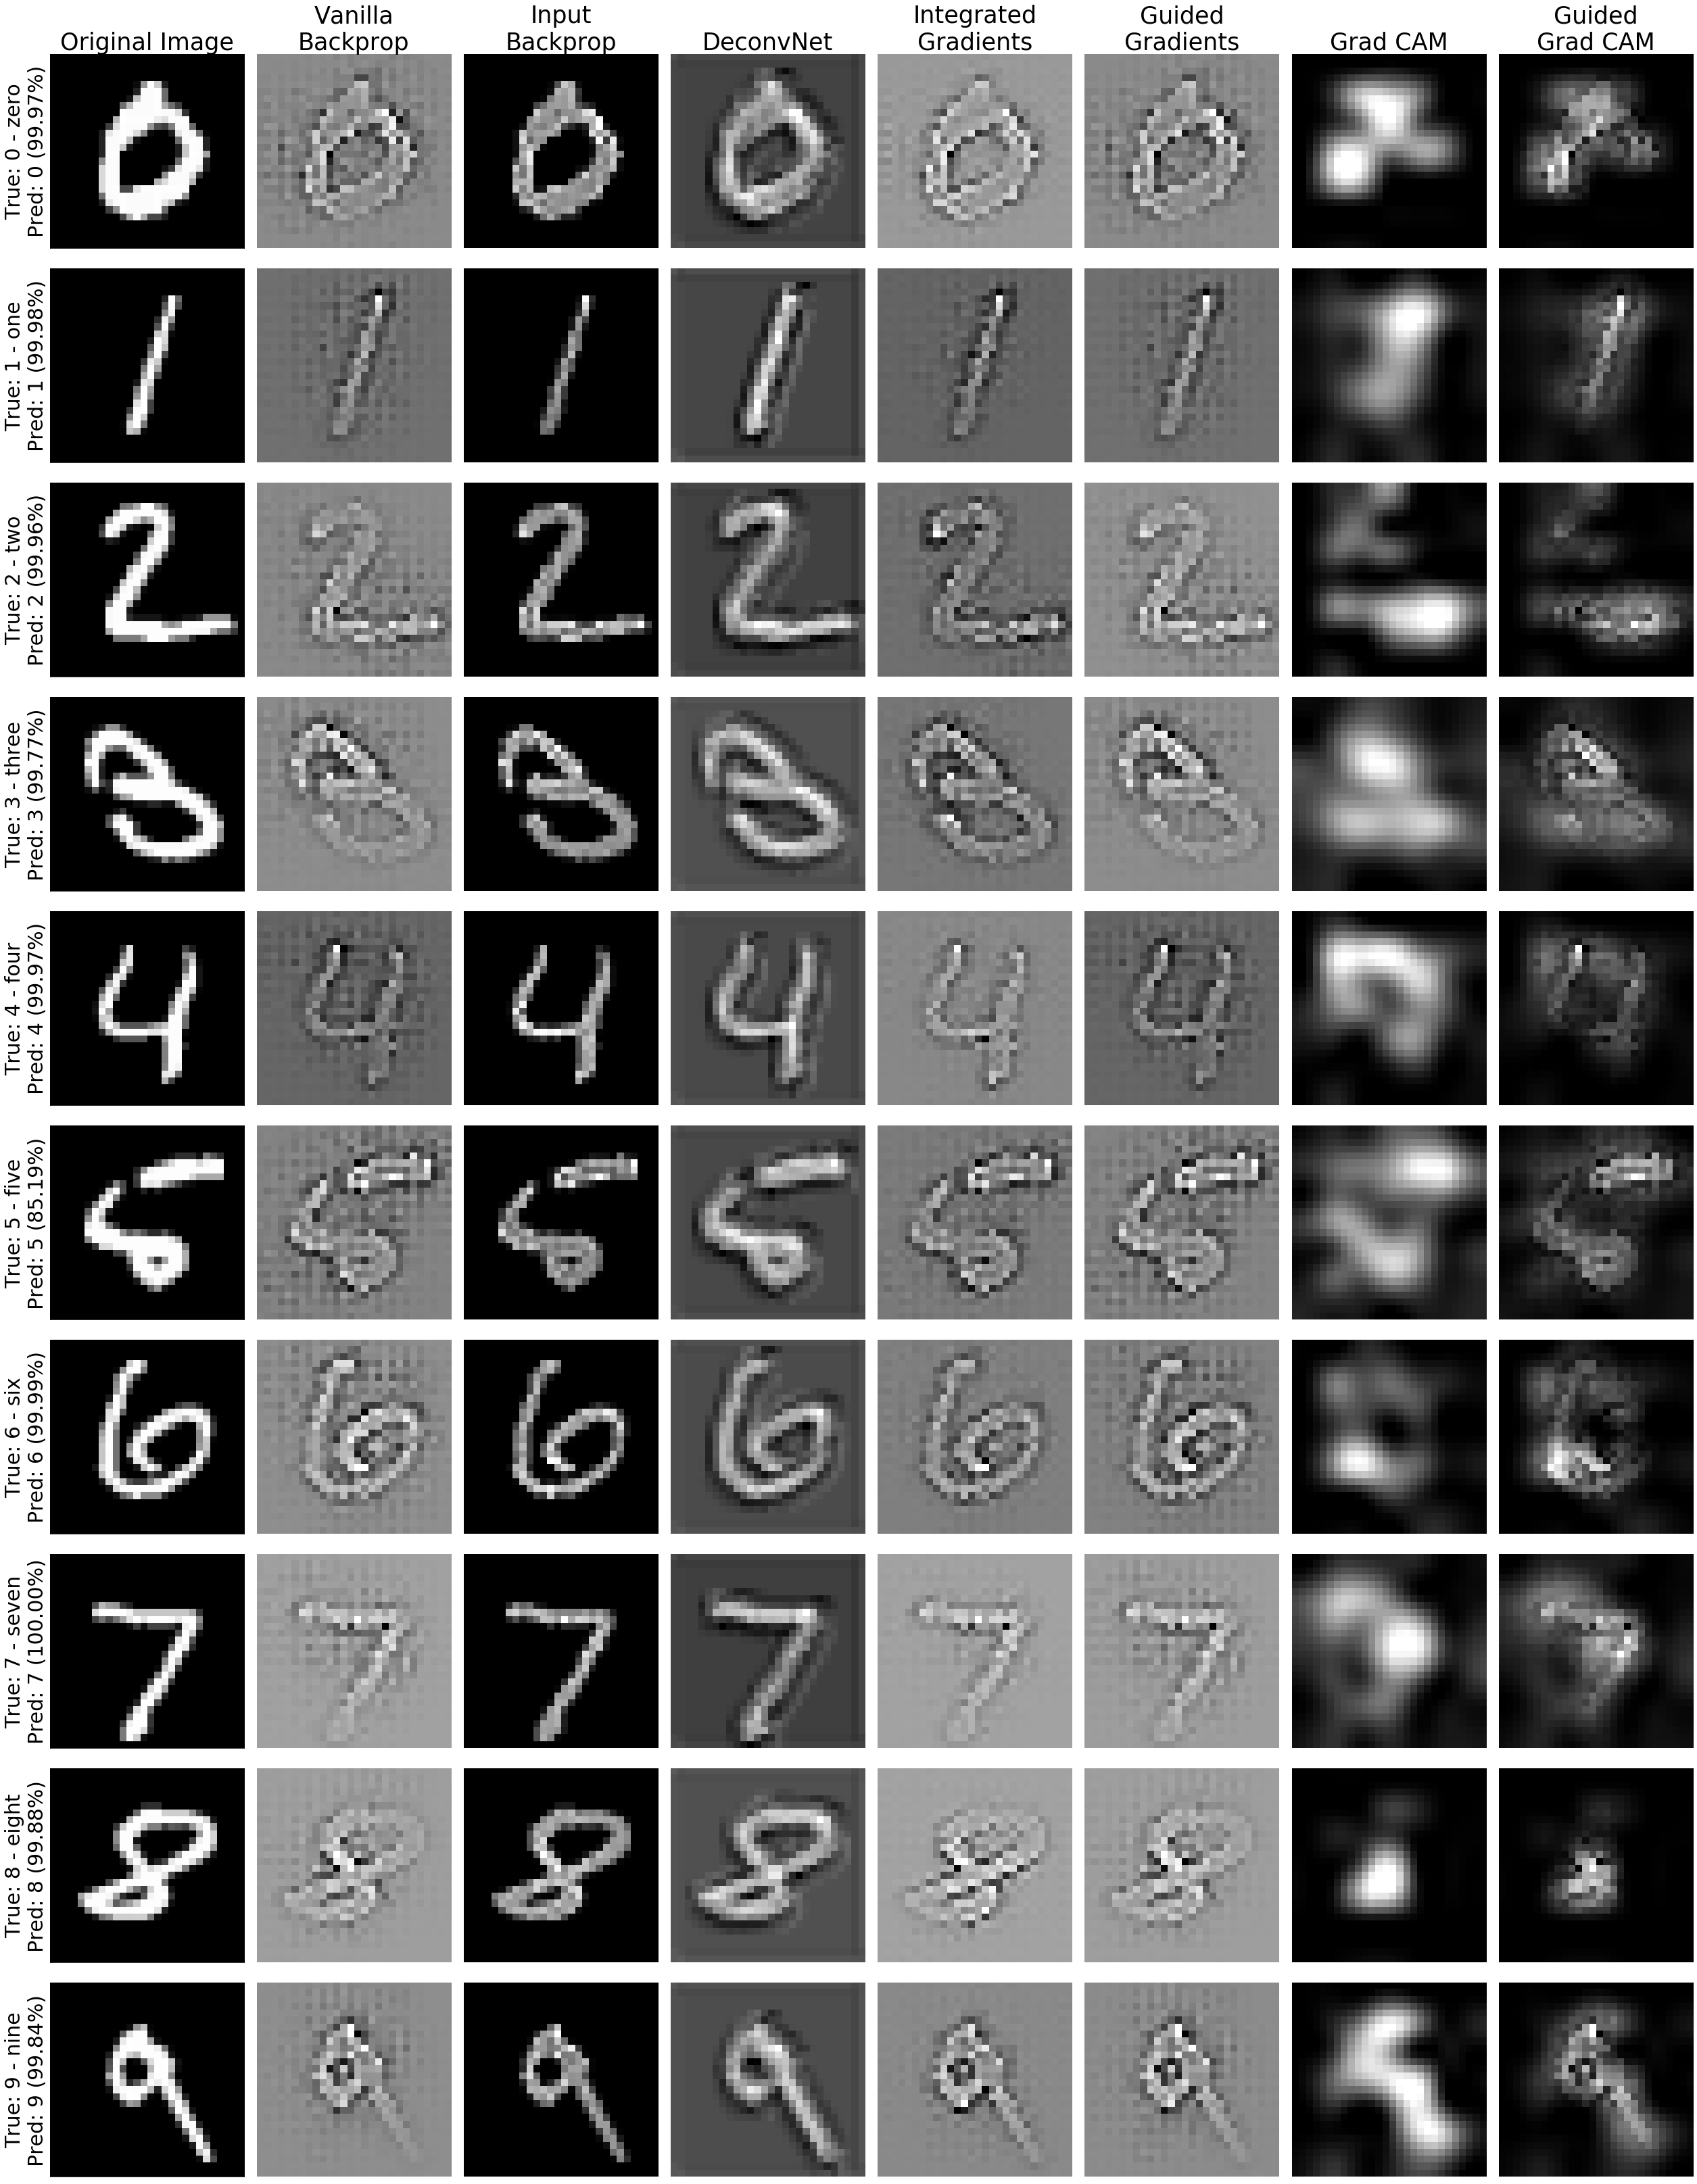

In [39]:
col = 8 # number of attribution methods + original image
row = 10 # number of class
f, ax = plt.subplots(row, col, figsize=(35,45))
# original images
for i in range(row):
    ax[i,0].imshow(original_images_mnist[i].squeeze(), 'gray')
    ax[i,0].set_ylabel('True: {0:}\nPred: {1:} ({2:.2%})'.format(mnist_classes[i], int(preds[i]), probs[i]), size=30)
    ax[i,0].set_xticks([])
    ax[i,0].set_yticks([])
    # set title
    if i == 0:
        ax[i,0].set_title('Original Image', size=35)

for i in range(row*(col-1)):
    r = i//(col-1)
    c = i%(col-1)
    ax[r,c+1].imshow(outputs[c,r].squeeze(), 'gray')
    ax[r,c+1].axis('off')
    # set title
    if r == 0:
        ax[r,c+1].set_title(method_lst[c], size=35)

plt.subplots_adjust(wspace=0, hspace=0)
plt.tight_layout()
plt.savefig('../images/results/coherence_mnist.jpg',dpi=150)

# CIFAR10

In [15]:
nb_class = 10
nb_methods = len(attr_methods_cifar10)
outputs = np.zeros((nb_methods, ) + original_images_cifar10.shape, dtype=np.float32)
probs = np.zeros(nb_class)
preds = np.zeros(nb_class)

In [24]:
for i in range(nb_class):
    img = pre_images_cifar10[i].unsqueeze(0)    
    p = cifar10_model(img)
    prob = p.max().item()
    pred = p.argmax().item()
    probs[i] = prob
    preds[i] = pred
    
    for m in range(nb_methods):
        output, _, _ = attr_methods_cifar10[m].generate_image(img, 0, i)
        if m == 5: # Grad CAM
            output, _, _ = attr_methods_cifar10[m].generate_image(img, 8, i)
            # GradCAM output shape is (W,H)
            output = cv2.applyColorMap(np.uint8(output*255), cv2.COLORMAP_JET)
            output = cv2.cvtColor(output, cv2.COLOR_BGR2RGB) / 255
        outputs[m,i] = output

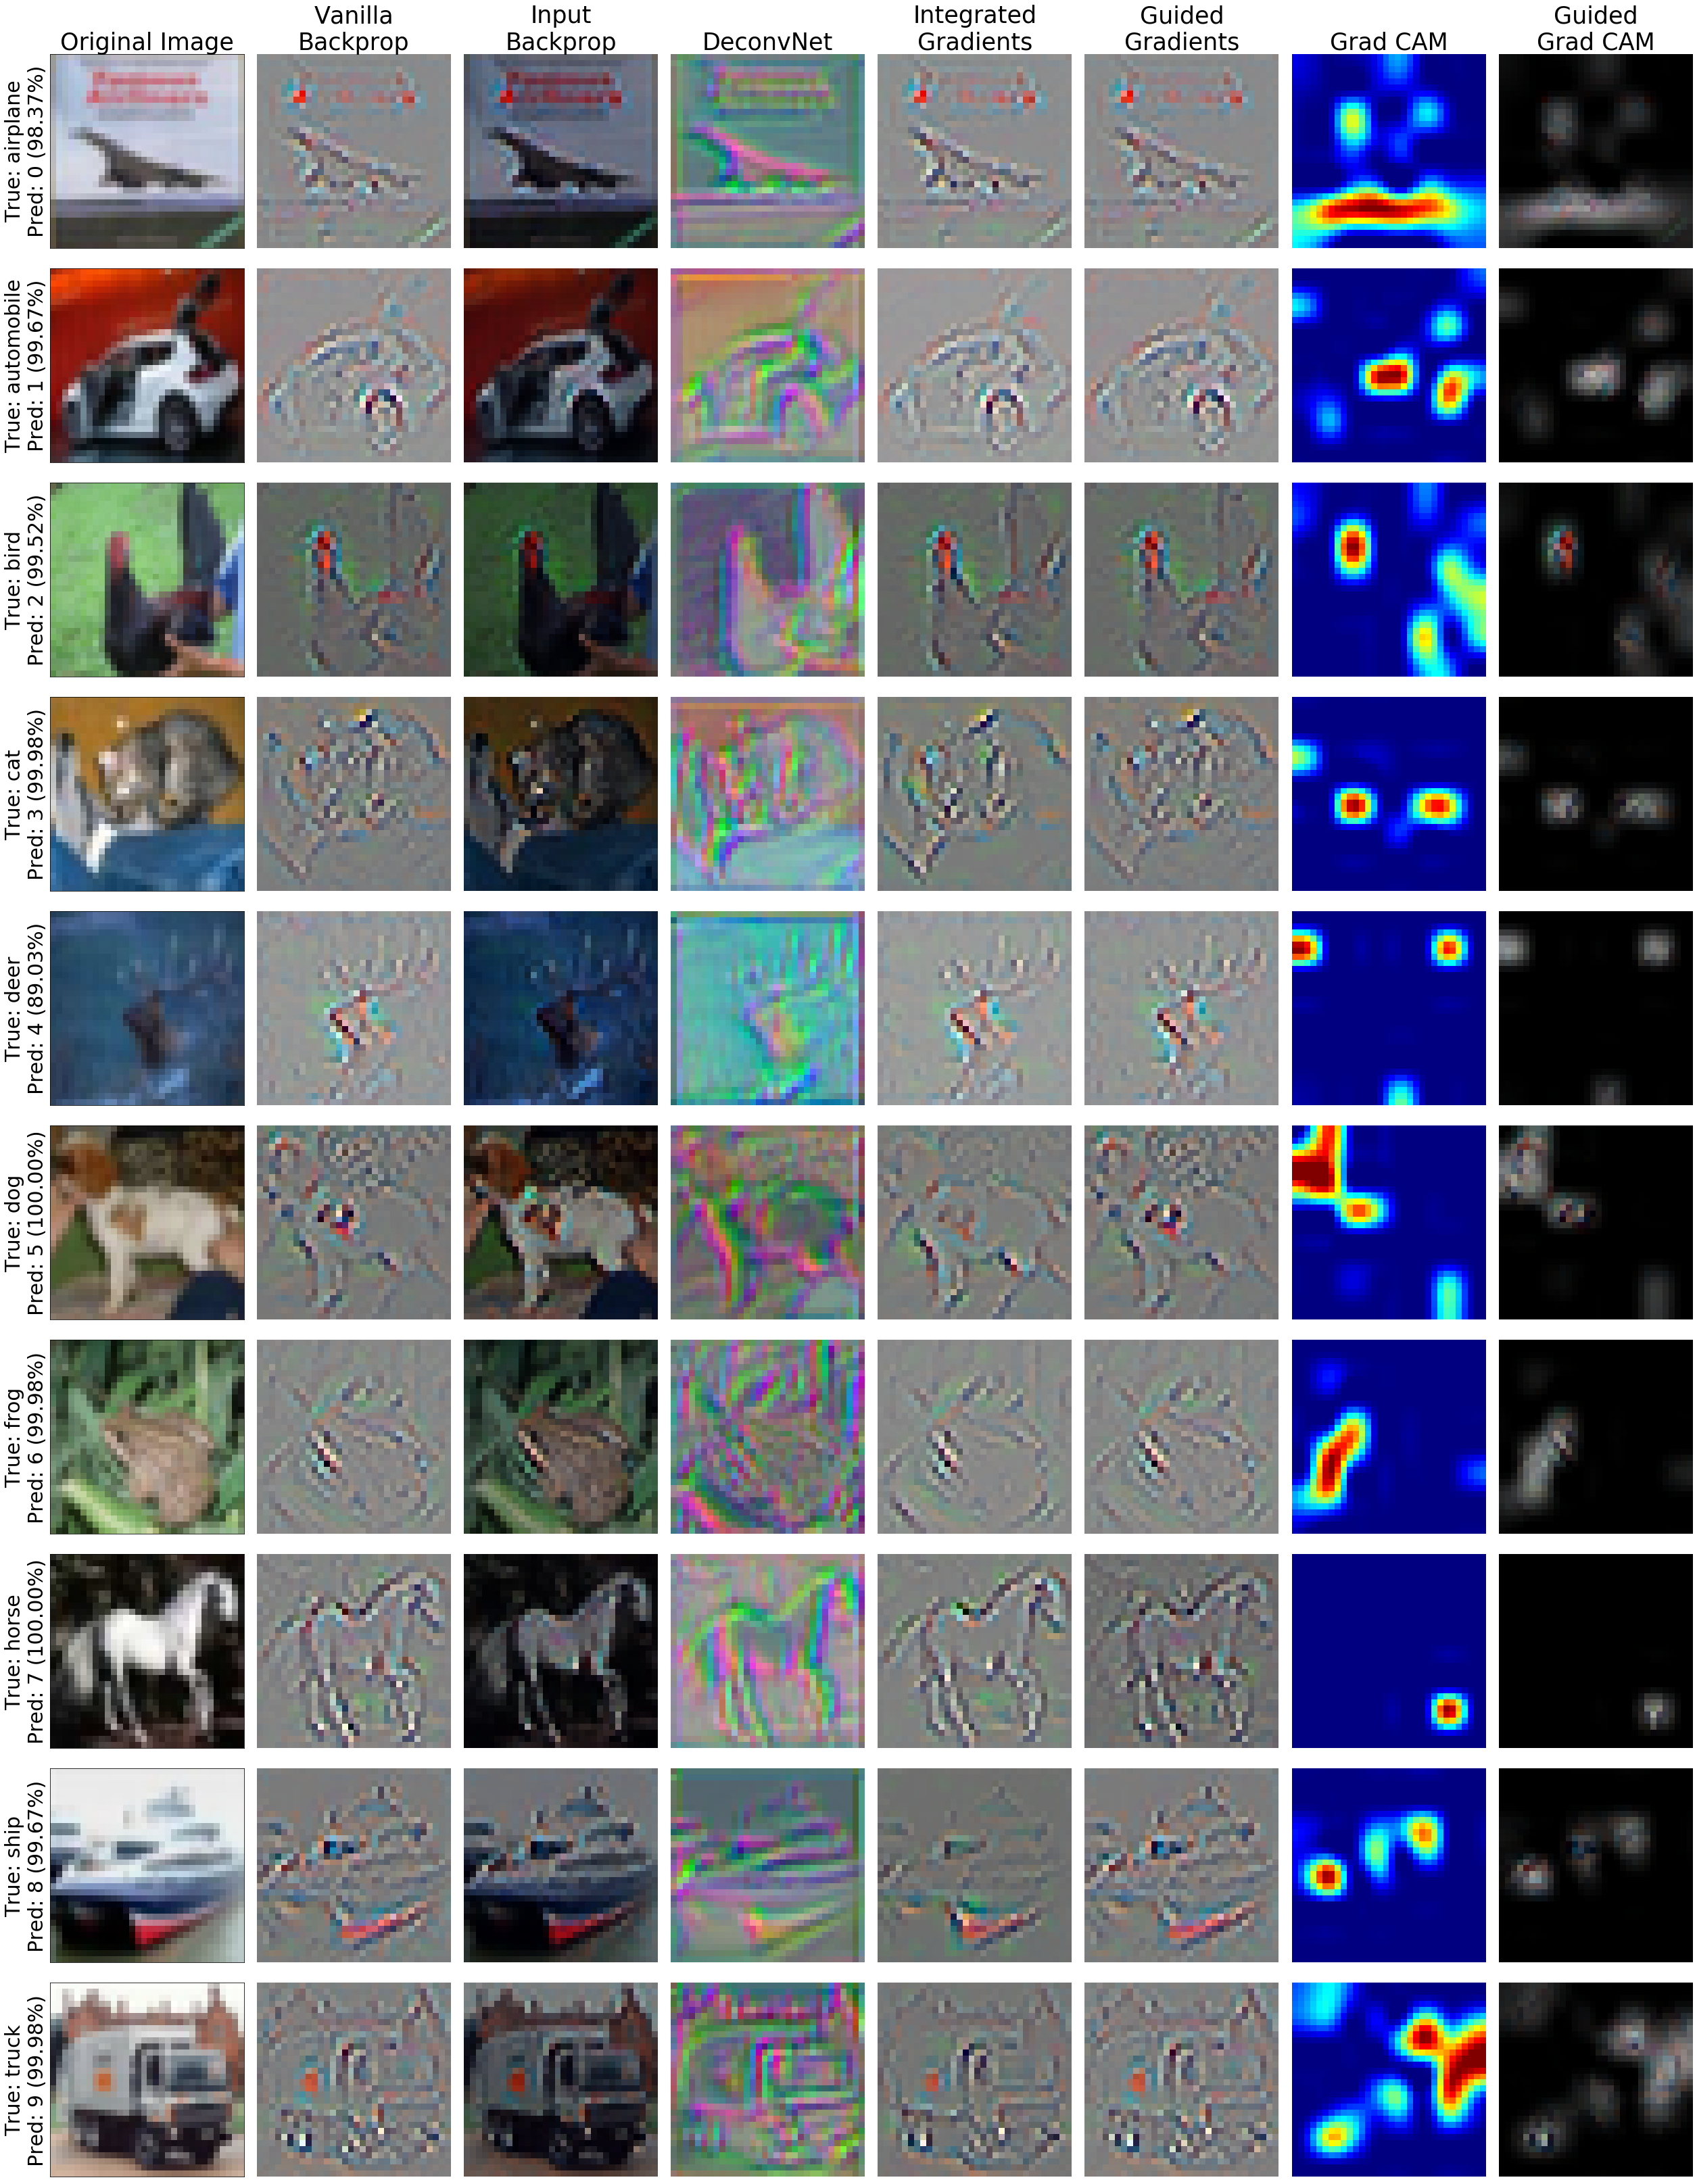

In [35]:
col = 8 # number of attribution methods + original image
row = 10 # number of class
f, ax = plt.subplots(row, col, figsize=(35,45))
# original images
for i in range(row):
    ax[i,0].imshow(original_images_cifar10[i])
    ax[i,0].set_ylabel('True: {0:}\nPred: {1:} ({2:.2%})'.format(cifar10_classes[i], int(preds[i]), probs[i]), size=30)
    ax[i,0].set_xticks([])
    ax[i,0].set_yticks([])
    # set title
    if i == 0:
        ax[i,0].set_title('Original Image', size=35)

for i in range(row*(col-1)):
    r = i//(col-1)
    c = i%(col-1)
    ax[r,c+1].imshow(outputs[c,r])
    ax[r,c+1].axis('off')
    # set title
    if r == 0:
        ax[r,c+1].set_title(method_lst[c], size=35)

plt.subplots_adjust(wspace=0, hspace=0)
plt.tight_layout()
plt.savefig('../images/results/coherence_cifar10.jpg',dpi=150)